# Nonlinear Stochastic Interpolant with Neural Spline Flows
## Testing on Checker Dataset

In [1]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2

import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from interflow.nonlinear_stochastic_interpolant import (
    NonlinearInterpolant, NonlinearSITrainer
)
from torch import autograd

# Check CUDA availability
if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    device = torch.device('cuda')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found, using CPU.')
    device = torch.device('cpu')
    
print(f"Using device: {device}")
print("Torch version:", torch.__version__)

No CUDA device found, using CPU.
Using device: cpu
Torch version: 2.7.1


## Define Utility Functions

In [2]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()

def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: float,
    bs: int
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(
        b=b,  
        method='dopri5', 
        interpolant=interpolant,
        n_step=3
    )
    
    with torch.no_grad():
        x0_tests = base(bs)
        xfs_sde = sde_flow.rollout_forward(x0_tests)
        xf_sde = grab(xfs_sde[-1].squeeze())
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    
    logp0 = base.log_prob(x0_tests)
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)
    logpx_pflow = logp0 + dlogp_pflow[-1].squeeze()
    xf_pflow = grab(xfs_pflow[-1].squeeze())
    
    return xf_sde, xf_pflow, logpx_pflow

def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int,
    counter: int,
    eps: float,
    data_dict: dict
):
    """Make plots to visualize samples and evolution of the likelihood."""
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    print(f"EPOCH: {counter}")
    
    # Plot losses
    epochs = np.arange(len(data_dict['losses']))
    axes[0].plot(epochs, data_dict['losses'], label="Total")
    axes[0].plot(epochs, data_dict['v_losses'], label="Velocity")
    axes[0].plot(epochs, data_dict['s_losses'], label="Score")
    axes[0].plot(epochs, data_dict['i_losses'], label="Interpolant", linestyle='--')
    axes[0].set_title("Losses")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot SDE samples
    axes[1].scatter(xf_sde[:, 0], xf_sde[:, 1], alpha=0.3, s=5)
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(-6.5, 6.5)
    axes[1].set_title("Samples from SDE")
    axes[1].grid(True, alpha=0.3)
    
    # Plot PFlow samples
    axes[2].scatter(xf_pflow[:, 0], xf_pflow[:, 1], alpha=0.3, s=5,
                   c=grab(torch.exp(logpx_pflow).detach()), cmap='viridis')
    axes[2].set_xlim(-5, 5)
    axes[2].set_ylim(-6.5, 6.5)
    axes[2].set_title("Samples from PFlow")
    axes[2].grid(True, alpha=0.3)
    
    # Plot log-likelihood
    axes[3].plot(epochs, data_dict['logps_pflow'], label='PFlow', color='purple')
    axes[3].set_title(r"$\log p$ from PFlow")
    axes[3].set_xlabel("Epoch")
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    fig.suptitle(f"Nonlinear SI with Neural Spline Flows (ε = {eps:.2f})", fontsize=14)
    plt.tight_layout()
    plt.show()

## Define Target Distribution (Checker)

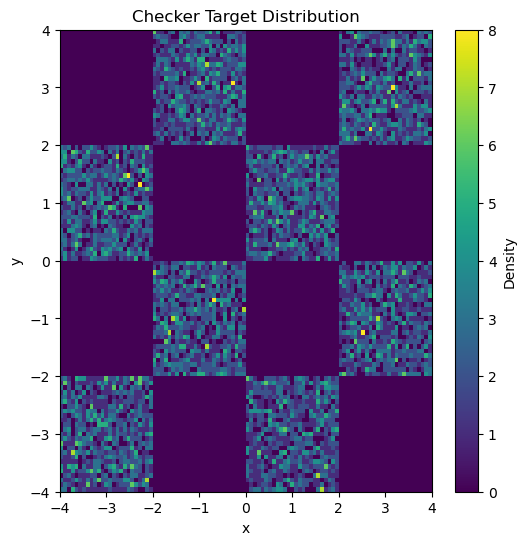

Target sample shape: (10000, 2)


In [3]:
ndim = 2

def target(bs):
    """Generate samples from checker distribution"""
    x1 = torch.rand(bs, device=device) * 4 - 2
    x2_ = torch.rand(bs, device=device) - torch.randint(2, (bs,), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

# Generate and visualize target samples
target_samples = grab(target(10000))

fig = plt.figure(figsize=(6, 6))
plt.hist2d(target_samples[:, 0], target_samples[:, 1], bins=100, range=[[-4, 4], [-4, 4]], cmap='viridis')
plt.colorbar(label='Density')
plt.title("Checker Target Distribution")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f"Target sample shape: {target_samples.shape}")

## Define Base Distribution (Gaussian)

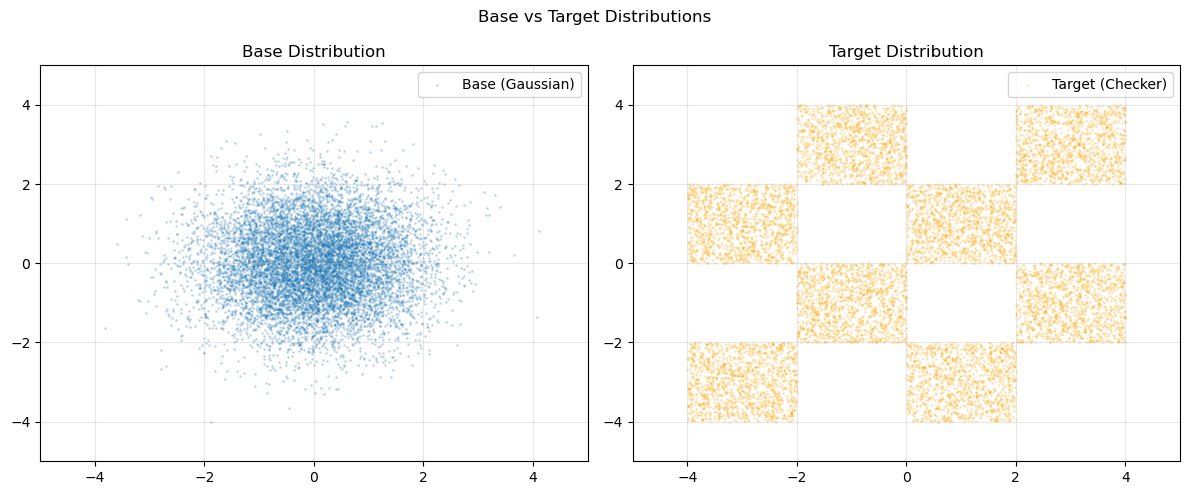

In [4]:
base_loc = torch.zeros(ndim, device=device)
base_var = torch.ones(ndim, device=device)
base = prior.SimpleNormal(base_loc, 1.0 * base_var)
base_samples = grab(base(10000))

# Visualize base vs target
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(base_samples[:, 0], base_samples[:, 1], alpha=0.2, s=1, label='Base (Gaussian)')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Base Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.2, s=1, label='Target (Checker)', color='orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Target Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Base vs Target Distributions")
plt.tight_layout()
plt.show()

## Initialize Nonlinear Stochastic Interpolant

In [5]:
# Create nonlinear interpolant with neural spline flows
path = 'one-sided-linear'  # One-sided interpolant with Gaussian base
interpolant = NonlinearInterpolant(
    dim=ndim,
    path=path,
    gamma_type=None,  # No stochastic component for one-sided
    n_layers=4,       # Number of coupling layers in NSF
    hidden_dims=128,  # Hidden dimensions in conditioner networks
    n_bins=8,         # Number of bins for rational quadratic splines
    tail_bound=3.0,   # Tail bound for splines
    device=device
)

print(f"Initialized Nonlinear Interpolant with {sum(p.numel() for p in interpolant.parameters())} parameters")

TypeError: CoupledRationalQuadraticSpline.__init__() got an unexpected keyword argument 'n_dims'

## Define Loss Functions

In [6]:
# Loss functions for velocity and score
loss_fn_v = stochastic_interpolant.make_loss(
    method='shared', 
    interpolant=interpolant, 
    loss_type='one-sided-v'
)

loss_fn_s = stochastic_interpolant.make_loss(
    method='shared', 
    interpolant=interpolant, 
    loss_type='one-sided-s'
)

NameError: name 'interpolant' is not defined

## Initialize Neural Networks for Velocity and Score

In [7]:
# Network architecture
hidden_sizes = [256, 256, 256, 256]
in_size = ndim + 1  # dimensions + time
out_size = ndim
inner_act = 'relu'
final_act = 'none'

# Create velocity and score networks
velocity_net = itf.fabrics.make_fc_net(
    hidden_sizes=hidden_sizes,
    in_size=in_size,
    out_size=out_size,
    inner_act=inner_act,
    final_act=final_act
).to(device)

score_net = itf.fabrics.make_fc_net(
    hidden_sizes=hidden_sizes,
    in_size=in_size,
    out_size=out_size,
    inner_act=inner_act,
    final_act=final_act
).to(device)

print(f"Velocity network parameters: {sum(p.numel() for p in velocity_net.parameters())}")
print(f"Score network parameters: {sum(p.numel() for p in score_net.parameters())}")

Velocity network parameters: 198914
Score network parameters: 198914


## Initialize Trainer with Max-Min Optimization

In [8]:
# Create trainer for nonlinear SI with max-min optimization
trainer = NonlinearSITrainer(
    interpolant=interpolant,
    velocity_net=velocity_net,
    score_net=score_net,
    lr_interpolant=1e-4,  # Learning rate for interpolant (NSF)
    lr_velocity=2e-3,     # Learning rate for velocity network
    lr_score=2e-3,        # Learning rate for score network
    device=device
)

print("Trainer initialized with max-min optimization")

NameError: name 'interpolant' is not defined

## Training Configuration

In [9]:
# Training hyperparameters
eps = 0.5           # Noise level for SDE
n_epochs = 5000     # Total training epochs
batch_size = 2000   # Batch size
plot_bs = 5000      # Batch size for plotting
metrics_freq = 50   # How often to compute metrics
plot_freq = 500     # How often to plot
n_save = 10         # Number of checkpoints for SDE
n_step = 100        # Number of SDE steps
n_inner_steps = 2   # Inner minimization steps in max-min

# Data storage
data_dict = {
    'losses': [],
    'v_losses': [],
    's_losses': [],
    'i_losses': [],
    'logps_pflow': [],
}

print(f"Training configuration:")
print(f"  - Epochs: {n_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Inner steps: {n_inner_steps}")
print(f"  - Device: {device}")

Training configuration:
  - Epochs: 5000
  - Batch size: 2000
  - Inner steps: 2
  - Device: cpu


## Training Loop

In [10]:
print("Starting training...")
print("-" * 50)

for epoch in range(1, n_epochs + 1):
    # Generate batch
    x0 = base(batch_size)
    x1 = target(batch_size)
    
    # Training step with max-min optimization
    losses = trainer.train_step(
        x0=x0,
        x1=x1,
        loss_fn_v=loss_fn_v,
        loss_fn_s=loss_fn_s,
        n_inner_steps=n_inner_steps
    )
    
    # Log metrics
    if (epoch - 1) % metrics_freq == 0:
        data_dict['losses'].append(losses['total'])
        data_dict['v_losses'].append(losses['velocity'])
        data_dict['s_losses'].append(losses['score'])
        data_dict['i_losses'].append(losses['interpolant'])
        
        # Compute likelihood
        with torch.no_grad():
            _, _, logpx_pflow = compute_likelihoods(
                velocity_net, score_net, interpolant, 
                n_save, n_step, eps, batch_size
            )
            data_dict['logps_pflow'].append(grab(logpx_pflow).mean())
    
    # Progress printing
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Loss: {losses['total']:.4f} | "
              f"V: {losses['velocity']:.4f} | "
              f"S: {losses['score']:.4f} | "
              f"I: {losses['interpolant']:.4f}")
    
    # Plotting
    if (epoch - 1) % plot_freq == 0 and epoch > 1:
        make_plots(
            velocity_net, score_net, interpolant,
            n_save, n_step, plot_bs, epoch, eps, data_dict
        )

print("-" * 50)
print("Training completed!")

Starting training...
--------------------------------------------------


NameError: name 'trainer' is not defined

## Final Evaluation and Visualization

In [11]:
# Generate final samples
print("Generating final samples...")

with torch.no_grad():
    # Generate samples using trained model
    n_final_samples = 10000
    x0_final = base(n_final_samples)
    
    # PFlow sampling
    pflow = stochastic_interpolant.PFlowIntegrator(
        b=velocity_net,
        method='dopri5',
        interpolant=interpolant,
        n_step=5
    )
    xf_pflow, logp_pflow = pflow.rollout(x0_final)
    xf_pflow_np = grab(xf_pflow[-1].squeeze())
    
    # SDE sampling
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=velocity_net,
        s=score_net,
        eps=eps,
        interpolant=interpolant,
        n_save=1,
        n_step=100
    )
    xf_sde = sde_flow.rollout_forward(x0_final[:1000])  # Smaller batch for SDE
    xf_sde_np = grab(xf_sde[-1].squeeze())

# Create final visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Target distribution
axes[0, 0].hist2d(target_samples[:, 0], target_samples[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 0].set_title("Target Distribution", fontsize=12)
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")

# PFlow samples
axes[0, 1].hist2d(xf_pflow_np[:, 0], xf_pflow_np[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 1].set_title("PFlow Samples", fontsize=12)
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")

# SDE samples
axes[0, 2].hist2d(xf_sde_np[:, 0], xf_sde_np[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 2].set_title("SDE Samples", fontsize=12)
axes[0, 2].set_xlabel("x")
axes[0, 2].set_ylabel("y")

# Training curves
epochs = np.arange(len(data_dict['losses'])) * metrics_freq

axes[1, 0].plot(epochs, data_dict['losses'], label='Total', linewidth=2)
axes[1, 0].plot(epochs, data_dict['v_losses'], label='Velocity', alpha=0.7)
axes[1, 0].plot(epochs, data_dict['s_losses'], label='Score', alpha=0.7)
axes[1, 0].set_title("Training Losses", fontsize=12)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Interpolant loss
axes[1, 1].plot(epochs, data_dict['i_losses'], color='green', linewidth=2)
axes[1, 1].set_title("Interpolant Loss (Adversarial)", fontsize=12)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].grid(True, alpha=0.3)

# Log-likelihood
axes[1, 2].plot(epochs, data_dict['logps_pflow'], color='purple', linewidth=2)
axes[1, 2].set_title("Log-Likelihood Evolution", fontsize=12)
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel(r"$\log p$")
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle("Nonlinear Stochastic Interpolant Results", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nFinal Statistics:")
print(f"  - Final total loss: {data_dict['losses'][-1]:.4f}")
print(f"  - Final log-likelihood: {data_dict['logps_pflow'][-1]:.4f}")
print(f"  - Number of NSF parameters: {sum(p.numel() for p in interpolant.parameters())}")
print(f"  - Total trainable parameters: {sum(p.numel() for p in interpolant.parameters()) + sum(p.numel() for p in velocity_net.parameters()) + sum(p.numel() for p in score_net.parameters())}")

Generating final samples...


NameError: name 'interpolant' is not defined

## Visualize Interpolation Path

In [ ]:
# Visualize the learned nonlinear interpolation path
print("Visualizing interpolation path...")

with torch.no_grad():
    # Sample a few points
    n_viz = 100
    x0_viz = base(n_viz)
    x1_viz = target(n_viz)
    
    # Time points along the path
    t_points = torch.linspace(0, 1, 11, device=device)
    
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    axes = axes.flatten()
    
    for i, t in enumerate(t_points):
        if i >= 11:
            axes[i].axis('off')
            continue
            
        # Compute interpolated points
        t_batch = t.expand(n_viz)
        
        # For one-sided interpolant
        if interpolant.path in ['one-sided-linear', 'one-sided-trig']:
            xt = interpolant.It(t_batch, x0_viz, x1_viz)
        else:
            xt, _ = interpolant.calc_xt(t_batch, x0_viz, x1_viz)
        
        xt_np = grab(xt)
        
        # Plot
        axes[i].scatter(xt_np[:, 0], xt_np[:, 1], alpha=0.5, s=10)
        axes[i].set_xlim(-5, 5)
        axes[i].set_ylim(-5, 5)
        axes[i].set_title(f"t = {t.item():.1f}", fontsize=10)
        axes[i].grid(True, alpha=0.3)
        
        if i == 0:
            axes[i].set_ylabel("y")
        if i >= 6:
            axes[i].set_xlabel("x")
    
    # Turn off the last axis
    axes[-1].axis('off')
    
    plt.suptitle("Nonlinear Interpolation Path from Base to Target", fontsize=14)
    plt.tight_layout()
    plt.show()

print("Visualization complete!")

## Save Trained Models

In [ ]:
# Save the trained models
import os

save_dir = "../saved_models/nonlinear_si/"
os.makedirs(save_dir, exist_ok=True)

# Save model states
torch.save({
    'interpolant_state': interpolant.T_t.state_dict(),
    'velocity_state': velocity_net.state_dict(),
    'score_state': score_net.state_dict(),
    'training_history': data_dict,
    'config': {
        'dim': ndim,
        'path': path,
        'n_layers': 4,
        'hidden_dims': 128,
        'n_bins': 8,
        'eps': eps,
        'n_epochs': n_epochs
    }
}, os.path.join(save_dir, 'nonlinear_si_checker.pt'))

print(f"Models saved to {save_dir}")